In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.color import rgb2gray
import skimage.io as io
import skimage.transform as transform
from skimage.exposure import equalize_hist
from PIL import Image
import ipywidgets as widgets
from __future__ import print_function
from ipywidgets import interact_manual
from random import randint
from IPython.display import display
from IPython.display import clear_output
from skimage.io import imread
from skimage.feature import corner_harris , corner_subpix, corner_peaks
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
# Obtención de imagenes.
dataimg = []
ps = 'pastor suizo'
pb = 'pasto belga'
pa = 'pastor aleman'

for i in range(225):
    dataimg.append(io.imread('dataPastor/pastor ('+str(i+1)+').jpg'))

# Etiqueta de imagenes manualmente
array = []
for i in range(225):
    if i<75:
        array.append(ps)
    elif i<150:
        array.append(pb)
    else:
        array.append(pa)

In [10]:
# creamos la matriz de imagenes
def mostrarImagenes(img=[]):
    #definir el tamaño de la configuracion de la matriz de imagenes
    fig = plt.figure(figsize=(15,15))
    fig.subplots_adjust(left=0,right=1, bottom=0, top=1, hspace=0.05, wspace=0.0)
    for i in range(225):
        #dibujar las iagenes en una matriz de 15x15
        d = fig.add_subplot(15, 15, i + 1, xticks=[], yticks=[])
        d.imshow(img[i],interpolation='nearest')
        d.text(10,40, str(array[i]), bbox=dict(facecolor='green',alpha=1))

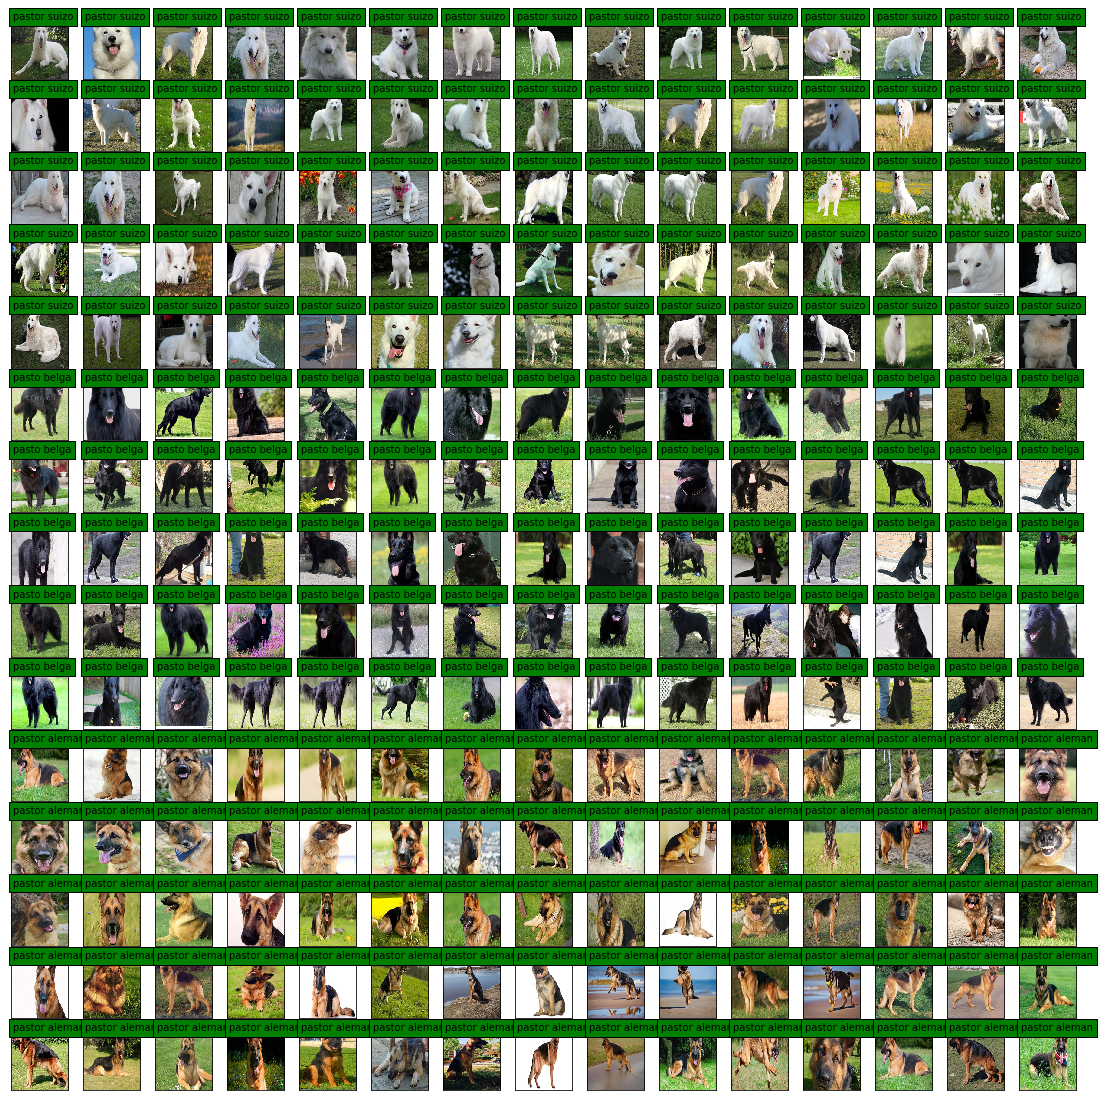

In [11]:
#LLamamos la funcion creada
mostrarImagenes(dataimg)

# PREPROCESAMIENTO DE LAS IMAGENES

In [16]:
# Transformar pixeles a np.array
img = []
for i in range(225):
    data = io.imread('dataPastor/pastor ('+str(i+1)+').jpg')
    data = equalize_hist(rgb2gray(data))
    data = data.reshape(data.size,)
    img.append(data)

In [18]:
# Comprobar pixeles de las imagenes
si = 0
no = 0

for i in range(225):
    a = len(img[i])
    if i < 99:
        b = len(img[i+1])
    if a == b:
        si+=1
    else:
        no+=1
print(si,no)

225 0


In [22]:
# Frame imagenes con etiquetas
frameMosaico = pd.DataFrame({'img':img,'etiqueta':array})
frameMosaico.head(5)

,etiqueta,img
0,pastor suizo,"[0.02897850436564731, 0.007650463054984695, 0...."
1,pastor suizo,"[0.08300009634854268, 0.08300009634854268, 0.0..."
2,pastor suizo,"[0.8048690489300575, 0.8018905377181473, 0.795..."
3,pastor suizo,"[0.936223568911817, 0.9244259514444567, 0.9432..."
4,pastor suizo,"[0.9425003096546111, 0.9432565497212131, 0.952..."


# EXTRACCIÓN DE CARACTERISTICAS

In [40]:
imagenes = []
corner = []
fotos = {}
fotos.setdefault('image',[])
fotos.setdefault('corner',[])
fotos.setdefault('target',[])
fotos.setdefault('name',[])

def caracteristicas(image = []):
        #Leer una imagen
        for i in range(225):
            img = image[i]
            img = rgb2gray(img)
            
            #Implementamos el computo de Harris de la imagen.
            #por cada pixel en la esquina que responde por cada pixel de la imagen
            
            corners = corner_harris(img)
            
            #Usamos las esquinas resultantes de las imagenes que calculamos
            #Se recalcula para obtener las esquinas más relevantes
            
            coords = corner_peaks(corners,min_distance=5)
            
            # Esta funcion decide si un punto esquina es una caracteristica importante o es un punto aislado
            coords_subpix = corner_subpix(img,coords,window_size=13)
            
            #Creamos una condicion para evitar errores en el momento de agregar información al diccionario
            if(coords.shape == (0,2)):
                continue
            #redimensionalidad de la imagen
            corn = coords.reshape(coords.size,)
            imag = img.reshape(img.size,)
            
            #Guardamos los datos en un diccionario
            
            fotos['image'].append(imag)
            fotos['corner'].append(len(corn))
            fotos['target'].append(i)
            fotos['name'].append(array[i])

In [41]:
caracteristicas(dataimg)
mosaico = pd.DataFrame(fotos,columns = fotos.keys())

# Creacion de vectores de características

In [92]:
from sklearn.model_selection import train_test_split
X_train,x_test,y_train,y_test = train_test_split(fotos['image'],fotos['name'],random_state=0,test_size=0.45)

In [93]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

In [94]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [95]:
mosaico.head()

,image,corner,target,name
0,"[0.12463490196078433, 0.09718392156862746, 0.1...",78,0,pastor suizo
1,"[0.44270274509803925, 0.44270274509803925, 0.4...",20,1,pastor suizo
2,"[0.6296098039215685, 0.6256882352941177, 0.617...",18,2,pastor suizo
3,"[0.8672262745098038, 0.8467850980392158, 0.927...",2,3,pastor suizo
4,"[0.9732501960784314, 0.9749168627450981, 0.985...",2,4,pastor suizo


In [96]:
prediction = dtree.predict(x_test)
print(len(prediction))

99


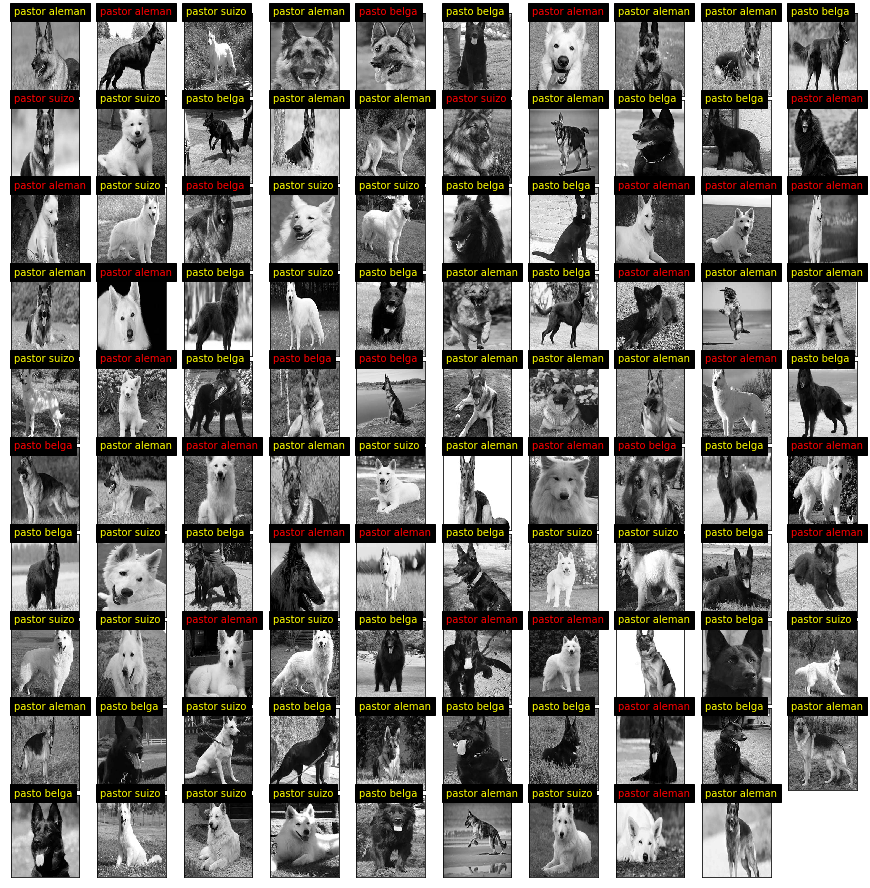

In [97]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(left=0,right=1, bottom=0, top=1, hspace=0.05, wspace=0.0)
cont1=0
for i in range(len(prediction)):
#dibujar las iagenes en una matriz de 15x15
    d = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    d.imshow(x_test[i].reshape((301,250)),cmap = 'gray',interpolation='nearest')
    
    #Etiquetas de cada imagen con target de tipo valor
    if prediction[i] == y_test[i]:
        d.text(10,5, str(prediction[i]),color = 'yellow',bbox=dict(facecolor='black',alpha=1))
        cont1+=1
    else:
        d.text(10,5, str(prediction[i]),color = 'red',bbox=dict(facecolor='black',alpha=1))
        cont1+=1

In [100]:
from sklearn.metrics import classification_report

In [101]:
print(classification_report(y_test,prediction))

               precision    recall  f1-score   support

  pasto belga       0.81      0.79      0.80        33
pastor aleman       0.51      0.74      0.61        31
 pastor suizo       0.91      0.57      0.70        35

  avg / total       0.75      0.70      0.70        99



In [104]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [105]:
rfc_pred = rfc.predict(x_test)

In [106]:
print(classification_report(y_test,rfc_pred))

               precision    recall  f1-score   support

  pasto belga       0.94      1.00      0.97        33
pastor aleman       0.88      0.94      0.91        31
 pastor suizo       1.00      0.89      0.94        35

  avg / total       0.94      0.94      0.94        99

